In [1]:
import dataclasses
import functools
import itertools

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import KetSugar as ks
import MaxLik as ml


samplings = np.load('probes_samplings.npz')
cal_sampl = samplings['n32']
test_sampl = samplings['n108']

cal_states = np.array([ks.BlochKet(theta, phi) for theta, phi in cal_sampl])
test_states = np.array([ks.BlochKet(theta, phi) for theta, phi in test_sampl])

MaxLik: Numba Allowed: True => use cycle-based K-vector construction


In [2]:
rotations_tomo_proj = np.array((
    (0,0),
    (np.pi,0),
    (np.pi/2, 0),
    (np.pi/2, np.pi),
    (np.pi/2, 1*np.pi/2),
    (np.pi/2, 3*np.pi/2)
))


# def get_assumed_rpv(errors):
#     coords = rotations_tomo_proj + errors.reshape((6,2))
#     coss = np.cos(coords[:,0]/2)
#     sins = np.sin(coords[:,0]/2)
#     exps = np.exp(1j*coords[:,1])
#     pis = np.zeros((6,2,1), dtype=np.complex128)
#     pis[:,0,0] = coss
#     pis[:,1,0] = sins*exps
#     return np.einsum('ki,kj->kij', pis.reshape((-1,2)), pis.conj().reshape((-1,2)))

def get_assumed_rpv(errors):
    coords = rotations_tomo_proj + errors.reshape((6,2))
    proj_kets = [ks.BlochKet(theta, phi) for theta, phi in coords]
    return np.array([ket @ ket.T.conjugate() for ket in proj_kets])

def simulate_tomograms_pc(probes_coord, errors, counts=1_000_000):
    tomograms = []
    noise = 0.001
    rpv_true = get_assumed_rpv(errors)
    for theta, phi in probes_coord:
        probe_ket = ks.BlochKet(theta, phi)
        tomogram = np.array([ks.ExpectationValue(probe_ket, proj).real for proj in rpv_true])         
        tomograms.append(tomogram*(1-noise) + noise)
    tomograms = np.array(tomograms)
    return np.random.poisson(tomograms*counts)

def simulate_tomograms_pc_noiseless(probes_coord, errors):
    tomograms = []
    noise = 0.001
    rpv_true = get_assumed_rpv(errors)
    for theta, phi in probes_coord:
        probe_ket = ks.BlochKet(theta, phi)
        tomogram = np.array([ks.ExpectationValue(probe_ket, proj).real for proj in rpv_true])         
        tomograms.append(tomogram*(1-noise) + noise)
    tomograms = np.array(tomograms)
    return tomograms


butterfly = lambda x: ks.ketbra(x, x)


def rotation_y(alpha):
    return butterfly(ks.CLO) + np.exp(1j*alpha)*butterfly(ks.CHI)

def rotation_z(alpha):
    return butterfly(ks.LO) + np.exp(1j*alpha)*butterfly(ks.HI)

def find_rot(observed, ideal):
    def cost_f(args):
        y, z = args
        u = rotation_z(z) @ rotation_y(y)
        value = sum([np.abs((ks.dagger(ket_j) @ u @ ket_i)[0,0])**2 for ket_i, ket_j in zip(observed, ideal)])
        return -value
    x0 = np.random.normal(0, 0.001, 2)
    optimum = minimize(cost_f, x0 = x0)
    return optimum

def try_to_fix_unitary(desired_kets, observed_rhos):
    observed_kets = [np.linalg.eigh(rho)[1][:,-1].reshape((2,1)) for rho in observed_rhos]
    optimum = find_rot(observed_kets, desired_kets)
    
    y, z = optimum['x']
    try:
        assert optimum['success']
        u = rotation_z(z) @ rotation_y(y)    
        return u
    except:
        print("Ooops, unitary finding failed.")
        return np.eye(2)

In [3]:
ML_ITERS = 10000
ML_THR = 1e-7

def map_tomograms(tomos, pis):
    return np.array([ml.Reconstruct(t, pis, ML_ITERS, ML_THR, RhoPiVect = True, Renorm = True) for t in tomos])

@dataclasses.dataclass
class AnalysisData:
    pur_naive : np.ndarray
    pur_true  : np.ndarray
    pur_opt   : np.ndarray
    fid_naive : np.ndarray
    fid_true  : np.ndarray
    fid_opt   : np.ndarray
    rhos_opt  : np.ndarray
    rot_op    : np.ndarray

@dataclasses.dataclass
class PostAnalysisData:
    nai_min_pur : float
    nai_ptp_pur : float
    tru_min_pur : float
    tru_ptp_pur : float    
    opt_min_pur : float
    opt_ptp_pur : float    
    #-----
    nai_min_fid : float
    nai_mean_fid : float
    tru_min_fid : float
    tru_mean_fid : float    
    opt_min_fid : float
    opt_mean_fid : float    



def postanalyze(analysis : AnalysisData):
    #TODO: unitary rotation matching ... copy if from my github
    return PostAnalysisData(
        nai_min_pur = np.min(analysis.pur_naive),
        nai_ptp_pur = np.ptp(analysis.pur_naive),
        tru_min_pur = np.min(analysis.pur_true),
        tru_ptp_pur = np.ptp(analysis.pur_true),
        opt_min_pur = np.min(analysis.pur_opt),
        opt_ptp_pur = np.ptp(analysis.pur_opt),
        nai_min_fid = np.min(analysis.fid_naive),
        nai_mean_fid = np.mean(analysis.fid_naive),
        tru_min_fid = np.min(analysis.fid_true),
        tru_mean_fid = np.mean(analysis.fid_true),
        opt_min_fid = np.min(analysis.fid_opt),
        opt_mean_fid = np.mean(analysis.fid_opt)
    )

def preanalyze(tomos, optim_err, true_err, reference_kets, fix_rot=False):
    selected_test_probe_indices = [0, 5, 10]
    

    pi_opt = get_assumed_rpv(optim_err)
    pi_true = get_assumed_rpv(true_err)
    pi_naive = get_assumed_rpv(np.zeros(12))
    rho_opt = map_tomograms(tomos, pi_opt)
    rho_true = map_tomograms(tomos, pi_true)
    rho_naive = map_tomograms(tomos, pi_naive)

    Urot = np.eye(2)
    if fix_rot:
        desired_kets = [reference_kets[i] for i in selected_test_probe_indices]
        Urot = try_to_fix_unitary(desired_kets, rho_opt[selected_test_probe_indices])        
        rho_opt = np.array([ks.ApplyOp(r, Urot) for r in rho_opt])

    purs_naive = np.array([ks.Purity(r).real for r in rho_naive])
    purs_true = np.array([ks.Purity(r).real for r in rho_true])
    purs_opt = np.array([ks.Purity(r).real for r in rho_opt])

    fids_naive = np.array([ks.ExpectationValue(k, r).real for k, r in zip(reference_kets, rho_naive)])
    fids_true = np.array([ks.ExpectationValue(k, r).real for k, r in zip(reference_kets, rho_true)])
    fids_opt = np.array([ks.ExpectationValue(k, r).real for k, r in zip(reference_kets, rho_opt)])

    return AnalysisData(
        pur_naive = purs_naive,
        pur_true = purs_true,
        pur_opt = purs_opt,
        fid_naive = fids_naive,
        fid_true = fids_true,
        fid_opt = fids_opt,
        rhos_opt = rho_opt,
        rot_op=Urot
    )

def generate_tests(reference_coords, pis, shots):
    tomograms = []
    noise = 0.001
    reference_kets = []
    for theta, phi in reference_coords:
        probe_ket = ks.BlochKet(theta, phi)
        reference_kets.append(probe_ket)
        tomogram = np.array([ks.ExpectationValue(probe_ket, proj).real for proj in pis])         
        tomograms.append(tomogram*(1-noise) + noise)
    tomograms = np.array(tomograms)
    return np.random.poisson(tomograms*shots), np.array(reference_kets)

def analyze_tests(reference_coords, shots, optim_err, true_err, Urot=None):    
    pi_true = get_assumed_rpv(true_err)
    tomograms, reference_kets = generate_tests(reference_coords, pi_true, shots)
    analyzed = preanalyze(tomograms, optim_err, true_err, reference_kets, False)
    if Urot is not None:
        analyzed.rhos_opt = np.array([ks.ApplyOp(r, Urot) for r in analyzed.rhos_opt])
    return analyzed

def analyze_data(input_data_file, output_data_file, shots):
    inp_datas = np.load(input_data_file)
    calibration_tomos = inp_datas['test_data']
    true_value = inp_datas['truths']
    opt_results = np.genfromtxt(output_data_file)
    opt_params = opt_results[:, 2:]
    n = min(calibration_tomos.shape[0], opt_results.shape[0])
    results = []
    for index in tqdm(range(n)):
        # print(index, end='\r')
        calib_analysis = preanalyze(calibration_tomos[index], opt_params[index], true_value[index], cal_states, True)                
        test_analysis = analyze_tests(cal_sampl, shots, opt_params[index], true_value[index], calib_analysis.rot_op)
        post_calib_analysis = postanalyze(calib_analysis)
        post_test_analysis = postanalyze(test_analysis)
        results.append((post_calib_analysis, post_test_analysis))
    # print('.')
    return results

def analyze_bulk(results : list[PostAnalysisData]):
    print("Minimum purity:")
    nai_min_pur = np.array([(r_cal.nai_min_pur, r_test.nai_min_pur) for r_cal, r_test in results])
    mu_nai_min_pur = np.mean(nai_min_pur, axis=0)
    std_nai_min_pur = np.std(nai_min_pur, axis=0)

    print('Naive approach')
    print(f'Calib set: {mu_nai_min_pur[0]:.3e}+/-{std_nai_min_pur[0]:.3e}')
    print(f'Test set : {mu_nai_min_pur[1]:.3e}+/-{std_nai_min_pur[1]:.3e}')

    tru_min_pur = np.array([(r_cal.tru_min_pur , r_test.tru_min_pur) for r_cal, r_test in results])
    mu_tru_min_pur = np.mean(tru_min_pur, axis=0)
    std_tru_min_pur = np.std(tru_min_pur, axis=0)

    print('With true parameters')
    print(f'Calib set: {mu_tru_min_pur[0]:.3e}+/-{std_tru_min_pur[0]:.3e}')
    print(f'Test set : {mu_tru_min_pur[1]:.3e}+/-{std_tru_min_pur[1]:.3e}')

    opt_min_pur = np.array([(r_cal.opt_min_pur , r_test.opt_min_pur) for r_cal, r_test in results])
    mu_opt_min_pur = np.mean(opt_min_pur, axis=0)
    std_opt_min_pur = np.std(opt_min_pur, axis=0)

    print('With found parameters')
    print(f'Calib set: {mu_opt_min_pur[0]:.3e}+/-{std_opt_min_pur[0]:.3e}')
    print(f'Test set : {mu_opt_min_pur[1]:.3e}+/-{std_opt_min_pur[1]:.3e}')    

    print("\nMinimum fidelity:")
    nai_min_fid = np.array([(r_cal.nai_min_fid, r_test.nai_min_fid) for r_cal, r_test in results])
    mu_nai_min_fid = np.mean(nai_min_fid, axis=0)
    std_nai_min_fid = np.std(nai_min_fid, axis=0)

    print('Naive approach')
    print(f'Calib set: {mu_nai_min_fid[0]:.3e}+/-{std_nai_min_fid[0]:.3e}')
    print(f'Test set : {mu_nai_min_fid[1]:.3e}+/-{std_nai_min_fid[1]:.3e}')

    tru_min_fid = np.array([(r_cal.tru_min_fid , r_test.tru_min_fid) for r_cal, r_test in results])
    mu_tru_min_fid = np.mean(tru_min_fid, axis=0)
    std_tru_min_fid = np.std(tru_min_fid, axis=0)

    print('With true parameters')
    print(f'Calib set: {mu_tru_min_fid[0]:.3e}+/-{std_tru_min_fid[0]:.3e}')
    print(f'Test set : {mu_tru_min_fid[1]:.3e}+/-{std_tru_min_fid[1]:.3e}')

    opt_min_fid = np.array([(r_cal.opt_min_fid , r_test.opt_min_fid) for r_cal, r_test in results])
    mu_opt_min_fid = np.mean(opt_min_fid, axis=0)
    std_opt_min_fid = np.std(opt_min_fid, axis=0)

    print('With found parameters')
    print(f'Calib set: {mu_opt_min_fid[0]:.3e}+/-{std_opt_min_fid[0]:.3e}')
    print(f'Test set : {mu_opt_min_fid[1]:.3e}+/-{std_opt_min_fid[1]:.3e}')

    return np.array(
        [[
        [mu_nai_min_pur, std_nai_min_pur],
        [mu_tru_min_pur, std_tru_min_pur],
        [mu_opt_min_pur, std_opt_min_pur]
        ],
        [
        [mu_nai_min_fid, std_nai_min_fid],
        [mu_tru_min_fid, std_tru_min_fid],
        [mu_opt_min_fid, std_opt_min_fid]
        ]])

# pur/fid, nai/tru/opt, cal/test, mean/std
    

In [4]:
cnts_quantifier = '100k'
quants = ['100', '1k', '10k', '100k']
cnts = [100, 1000, 10_000, 100_000]

results_collection = []
for cnt, qant in zip(cnts, quants):
    print(cnt, qant)
    r = analyze_bulk(analyze_data(f'inputs/test_data_n32_5sigma_{qant}.npz', f'outputs/{qant}_results_n32.txt', cnt))
    results_collection.append(r)
results_collection = np.array(results_collection)

100 100


  0%|          | 0/50 [00:00<?, ?it/s]

Minimum purity:
Naive approach
Calib set: 8.433e-01+/-4.221e-02
Test set : 8.558e-01+/-3.766e-02
With true parameters
Calib set: 8.650e-01+/-3.711e-02
Test set : 8.774e-01+/-3.364e-02
With found parameters
Calib set: 9.592e-01+/-2.479e-02
Test set : 8.540e-01+/-5.026e-02

Minimum fidelity:
Naive approach
Calib set: 9.080e-01+/-2.618e-02
Test set : 9.127e-01+/-2.248e-02
With true parameters
Calib set: 9.230e-01+/-2.273e-02
Test set : 9.271e-01+/-2.052e-02
With found parameters
Calib set: 9.335e-01+/-2.957e-02
Test set : 8.940e-01+/-3.027e-02
1000 1k


  0%|          | 0/50 [00:00<?, ?it/s]

Minimum purity:
Naive approach
Calib set: 9.067e-01+/-2.477e-02
Test set : 9.068e-01+/-2.629e-02
With true parameters
Calib set: 9.544e-01+/-1.056e-02
Test set : 9.580e-01+/-1.005e-02
With found parameters
Calib set: 9.774e-01+/-4.924e-03
Test set : 9.451e-01+/-1.479e-02

Minimum fidelity:
Naive approach
Calib set: 9.488e-01+/-1.399e-02
Test set : 9.490e-01+/-1.498e-02
With true parameters
Calib set: 9.761e-01+/-5.628e-03
Test set : 9.781e-01+/-5.340e-03
With found parameters
Calib set: 9.850e-01+/-4.630e-03
Test set : 9.646e-01+/-1.289e-02
10000 10k


  0%|          | 0/50 [00:00<?, ?it/s]

Minimum purity:
Naive approach
Calib set: 9.184e-01+/-2.171e-02
Test set : 9.178e-01+/-2.197e-02
With true parameters
Calib set: 9.840e-01+/-3.918e-03
Test set : 9.847e-01+/-2.772e-03
With found parameters
Calib set: 9.896e-01+/-2.184e-03
Test set : 9.803e-01+/-4.592e-03

Minimum fidelity:
Naive approach
Calib set: 9.560e-01+/-1.206e-02
Test set : 9.556e-01+/-1.201e-02
With true parameters
Calib set: 9.919e-01+/-1.994e-03
Test set : 9.923e-01+/-1.406e-03
With found parameters
Calib set: 9.943e-01+/-1.555e-03
Test set : 9.859e-01+/-6.156e-03
100000 100k


  0%|          | 0/50 [00:00<?, ?it/s]

Minimum purity:
Naive approach
Calib set: 9.194e-01+/-2.450e-02
Test set : 9.197e-01+/-2.405e-02
With true parameters
Calib set: 9.934e-01+/-1.290e-03
Test set : 9.937e-01+/-9.122e-04
With found parameters
Calib set: 9.935e-01+/-1.967e-03
Test set : 9.910e-01+/-2.165e-03

Minimum fidelity:
Naive approach
Calib set: 9.567e-01+/-1.332e-02
Test set : 9.568e-01+/-1.301e-02
With true parameters
Calib set: 9.967e-01+/-6.501e-04
Test set : 9.968e-01+/-4.588e-04
With found parameters
Calib set: 9.965e-01+/-1.051e-03
Test set : 9.893e-01+/-7.260e-03


In [5]:
results_collection.shape

(4, 2, 3, 2, 2)

In [6]:
results_collection[0][0]

array([[[0.8433297 , 0.85583296],
        [0.04221288, 0.03766274]],

       [[0.86497467, 0.87739655],
        [0.03711317, 0.03363857]],

       [[0.95920448, 0.85395667],
        [0.02478752, 0.05026255]]])

In [7]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 2})

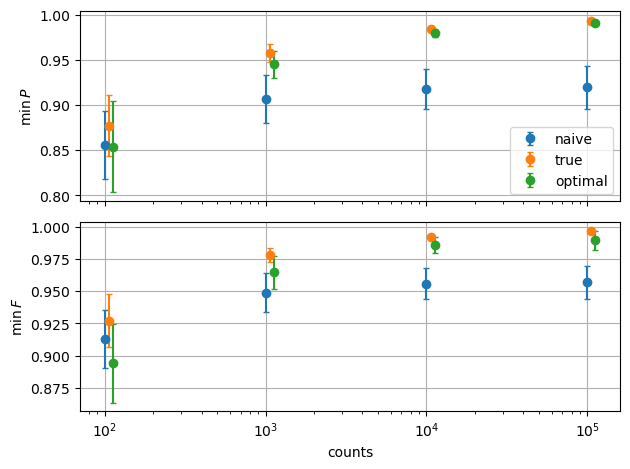

In [11]:

# pur/fid, nai/tru/opt, cal/test, mean/std
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

for i, label in enumerate(('naive','true', 'optimal')):
    x_vis_offset = (1+i/16)
    ax1.errorbar(x = np.array(cnts)*x_vis_offset, y = results_collection[:, 0, i, 0, 1], yerr = results_collection[:, 0, i, 1, 1], fmt="o", label=label)
    ax1.set_xscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('$\min\,P$')

for i, label in enumerate(('naive','true', 'optimal')):
    x_vis_offset = (1+i/16)
    ax2.errorbar(x = np.array(cnts)*x_vis_offset, y = results_collection[:, 1, i, 0, 1], yerr = results_collection[:, 1, i, 1, 1], fmt="o", label=label)
    ax2.set_xscale('log')
# ax2.legend()
ax2.set_xlabel('counts')
ax2.set_ylabel('$\min\,F$')
ax2.grid()
plt.tight_layout()
plt.show()